# PaiNN_Model

In [ ]:
import argparse
import ase
import itertools
import logging
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import sys
import time
import toml
import torch
from torch import nn
from ase.calculators.singlepoint import SinglePointCalculator
from ase.io import read, write, Trajectory
from pathlib import Path
from scipy.spatial import distance_matrix
from typing import List

logging.getLogger('matplotlib').setLevel(logging.WARNING)

## 数据预处理

In [ ]:
data = read('./data/train.xyz', index=':')
for atoms in data:
    calc = SinglePointCalculator(atoms, energy=atoms.info.pop('energy'), forces=atoms.arrays.pop('forces'))
    atoms.calc = calc
write('./data/train.traj', data)

data = read('./data/test.xyz', index=':')
for atoms in data:
    calc = SinglePointCalculator(atoms, energy=atoms.info.pop('energy'), forces=atoms.arrays.pop('forces'))
    atoms.calc = calc
write('./data/test.traj', data)

In [ ]:
class AseDataReader:
    def __init__(self, cutoff=6.5):            
        self.cutoff = cutoff
        
    def __call__(self, atoms):
        atoms_data = {
            'num_atoms': torch.tensor([atoms.get_global_number_of_atoms()]),
            'elems': torch.tensor(atoms.numbers),
            'coord': torch.tensor(atoms.positions, dtype=torch.float),
        }
        
        if atoms.pbc.any():
            pairs, n_diff = self.get_neighborlist(atoms)
            atoms_data['cell'] = torch.tensor(atoms.cell[:], dtype=torch.float)
        else:
            pairs, n_diff = self.get_neighborlist_simple(atoms)
        
        atoms_data['pairs'] = torch.from_numpy(pairs)
        atoms_data['n_diff'] = torch.from_numpy(n_diff).float()
        atoms_data['num_pairs'] = torch.tensor([pairs.shape[0]])
        
        try:
            energy = torch.tensor([atoms.get_potential_energy()], dtype=torch.float)
            atoms_data['energy'] = energy
        except (AttributeError, RuntimeError):
            pass
        
        try: 
            forces = torch.tensor(atoms.get_forces(apply_constraint=False), dtype=torch.float)
            atoms_data['forces'] = forces
        except (AttributeError, RuntimeError):
            pass
        
        return atoms_data
    
    def get_neighborlist(self, atoms):
        pos = atoms.get_positions()
        # 中心格子
        dist_mat = distance_matrix(pos, pos)
        mask = dist_mat < self.cutoff
        np.fill_diagonal(mask, False) # 矩阵mask的对角线全部设置为False    
        pairs = np.argwhere(mask) # 返回值为True的矩阵元索引
        pair_i_idx = pairs[:, 0]
        pair_j_idx = pairs[:, 1]
        n_diff = pos[pairs[:, 1]] - pos[pairs[:, 0]] # 返回pairs对应的原子间距 
        # 周期扩展的格子
        if atoms.pbc.any():
            for j in [-1, 0, 1]:
                for k in [-1, 0, 1]:
                    for l in [-1, 0, 1]:
                        if j==0 and k==0 and l==0:
                            continue
                        pos_pbc = atoms.get_positions()+ j * atoms.get_cell()[0] + k * atoms.get_cell()[1] + l * atoms.get_cell()[2]
                        dist_mat = distance_matrix(pos, pos_pbc)
                        mask = dist_mat < self.cutoff
                        pairs = np.argwhere(mask) # 返回值为True的矩阵元索引
                        pair_i_idx = np.append(pair_i_idx, pairs[:, 0])
                        pair_j_idx = np.append(pair_j_idx, pairs[:, 1]) 
                        n_diff = np.vstack((n_diff, (pos_pbc[pairs[:, 1]] - pos[pairs[:, 0]])))
            pairs = np.stack((pair_i_idx, pair_j_idx), axis=1)
            df = np.hstack((pairs, n_diff))
            df = df[np.argsort(df[:,0])]
            pairs, n_diff = np.hsplit(df, [2])
        return pairs, n_diff
    
    def get_neighborlist_simple(self, atoms):
        pos = atoms.get_positions()
        dist_mat = distance_matrix(pos, pos)
        mask = dist_mat < self.cutoff
        np.fill_diagonal(mask, False)        
        pairs = np.argwhere(mask)
        n_diff = pos[pairs[:, 1]] - pos[pairs[:, 0]]
        
        return pairs, n_diff
    
class AseDataset(torch.utils.data.Dataset):
    def __init__(self, ase_db, cutoff=6.5, **kwargs):
        super().__init__(**kwargs)
        
        if isinstance(ase_db, str):
            self.db = Trajectory(ase_db)
        else:
            self.db = ase_db 
            
        self.cutoff = cutoff
        self.atoms_reader = AseDataReader(cutoff)
        
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, idx):
        atoms = self.db[idx]
        atoms_data = self.atoms_reader(atoms)
        return atoms_data

def cat_tensors(tensors: List[torch.Tensor]):
    if tensors[0].shape:
        return torch.cat(tensors)
    return torch.stack(tensors)

def collate_atomsdata(atoms_data: List[dict], pin_memory=True):
    dict_of_lists = {k: [dic[k] for dic in atoms_data] for k in atoms_data[0]}
    if pin_memory:
        pin = lambda x: x.pin_memory()
    else:
        pin = lambda x: x  
        
    collated = {k: cat_tensors(v) for k, v in dict_of_lists.items()}
    return collated

def split_data(dataset, split_file=None, val_ratio=0.1):
    if split_file:
        with open(split_file, "r") as fp:
            splits = json.load(fp)
    else:
        datalen = len(dataset)
        num_validation = int(math.ceil(datalen * val_ratio))
        indices = np.random.permutation(len(dataset))
        splits = {
            "train": indices[num_validation:].tolist(),
            "validation": indices[:num_validation].tolist(),
        }

    with open("datasplits.json", "w") as f:
        json.dump(splits, f)

    datasplits = {}
    for key, indices in splits.items():
        datasplits[key] = torch.utils.data.Subset(dataset, indices)
    return datasplits

## 数据集示例

In [ ]:
dataset = AseDataset('./data/train.traj', 6.5)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collate_atomsdata)
next(iter(dataloader))

## 消息传递网络模型

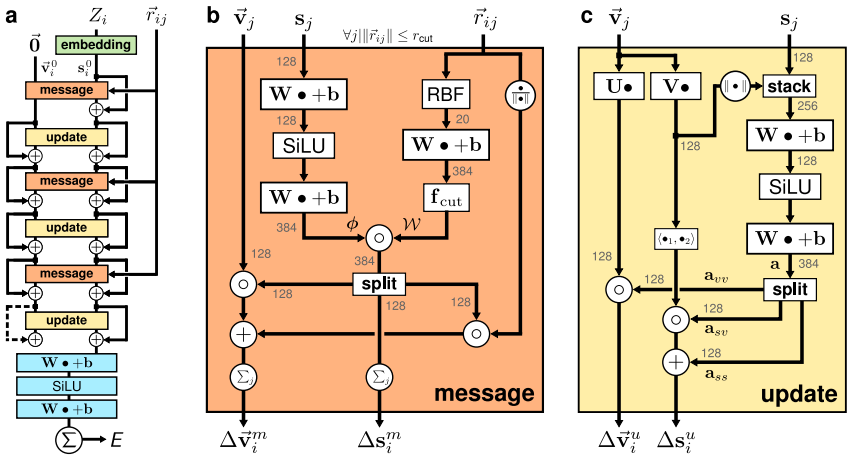

In [ ]:
def sinc_expansion(edge_dist: torch.Tensor, edge_size: int, cutoff: float):
    n = torch.arange(edge_size, device=edge_dist.device) + 1
    return torch.sin(edge_dist.unsqueeze(-1) * n * torch.pi / cutoff) / edge_dist.unsqueeze(-1)

def cosine_cutoff(edge_dist: torch.Tensor, cutoff: float):
    return torch.where(
        edge_dist < cutoff,
        0.5 * (torch.cos(torch.pi * edge_dist / cutoff) + 1),
        torch.tensor(0.0, device=edge_dist.device, dtype=edge_dist.dtype),
    )

class PainnMessage(nn.Module):
    """Message function"""
    def __init__(self, node_size: int, edge_size: int, cutoff: float):
        super().__init__()
        
        self.edge_size = edge_size
        self.node_size = node_size
        self.cutoff = cutoff
        
        self.scalar_message_mlp = nn.Sequential(
            nn.Linear(node_size, node_size),
            nn.SiLU(),
            nn.Linear(node_size, node_size * 3),
        )
        
        self.filter_layer = nn.Linear(edge_size, node_size * 3)
        
    def forward(self, node_scalar, node_vector, edge, edge_diff, edge_dist):
        edge = edge.long()  # 确保 edge 张量是 LongTensor 类型    
        filter_weight = self.filter_layer(sinc_expansion(edge_dist, self.edge_size, self.cutoff))
        filter_weight = filter_weight * cosine_cutoff(edge_dist, self.cutoff).unsqueeze(-1)
        scalar_out = self.scalar_message_mlp(node_scalar)        
        filter_out = filter_weight * scalar_out[edge[:, 1]]
        
        gate_state_vector, gate_edge_vector, message_scalar = torch.split(
            filter_out, 
            self.node_size,
            dim = 1,
        )
        
        # num_pairs * 3 * node_size, num_pairs * node_size
        message_vector =  node_vector[edge[:, 1]] * gate_state_vector.unsqueeze(1) 
        edge_vector = gate_edge_vector.unsqueeze(1) * (edge_diff / edge_dist.unsqueeze(-1)).unsqueeze(-1)
        message_vector = message_vector + edge_vector
        
        # sum message
        residual_scalar = torch.zeros_like(node_scalar)
        residual_vector = torch.zeros_like(node_vector)
        residual_scalar.index_add_(0, edge[:, 0], message_scalar)
        residual_vector.index_add_(0, edge[:, 0], message_vector)
        
        # new node state
        new_node_scalar = node_scalar + residual_scalar
        new_node_vector = node_vector + residual_vector
        
        return new_node_scalar, new_node_vector

class PainnUpdate(nn.Module):
    """Update function"""
    def __init__(self, node_size: int):
        super().__init__()
        
        self.update_U = nn.Linear(node_size, node_size)
        self.update_V = nn.Linear(node_size, node_size)
        
        self.update_mlp = nn.Sequential(
            nn.Linear(node_size * 2, node_size),
            nn.SiLU(),
            nn.Linear(node_size, node_size * 3),
        )
        
    def forward(self, node_scalar, node_vector):
        Uv = self.update_U(node_vector)
        Vv = self.update_V(node_vector)
        
        Vv_norm = torch.linalg.norm(Vv, dim=1)
        mlp_input = torch.cat((Vv_norm, node_scalar), dim=1)
        mlp_output = self.update_mlp(mlp_input)
        
        a_vv, a_sv, a_ss = torch.split(
            mlp_output,                                        
            node_vector.shape[-1],                                       
            dim = 1,
        )
        
        delta_v = a_vv.unsqueeze(1) * Uv
        inner_prod = torch.sum(Uv * Vv, dim=1)
        delta_s = a_sv * inner_prod + a_ss
        
        return node_scalar + delta_s, node_vector + delta_v

class PainnModel(nn.Module):
    """PainnModel without edge updating"""
    def __init__(
        self, 
        num_interactions, 
        hidden_state_size=128, 
        cutoff=6.5,
        normalization=True,
        target_mean=[0.0],
        target_stddev=[1.0],
        atomwise_normalization=True, 
        **kwargs,
    ):
        super().__init__()
        
        num_embedding = 119   # 总共 119 种元素
        self.cutoff = cutoff
        self.num_interactions = num_interactions
        self.hidden_state_size = hidden_state_size
        self.edge_embedding_size = 20
        
        # 绿色的原子嵌入层，包含 num_embedding 种元素，元素特征是 hidden_state_size 维
        self.atom_embedding = nn.Embedding(num_embedding, hidden_state_size)

        # 橙色和黄色的消息传递层
        self.message_layers = nn.ModuleList(
            [PainnMessage(self.hidden_state_size, self.edge_embedding_size, self.cutoff) for _ in range(self.num_interactions)]
        )
        self.update_layers = nn.ModuleList(
            [PainnUpdate(self.hidden_state_size) for _ in range(self.num_interactions)]            
        )
        
        # 蓝色的读出层
        self.readout_mlp = nn.Sequential(
            nn.Linear(self.hidden_state_size, self.hidden_state_size),
            nn.SiLU(),
            nn.Linear(self.hidden_state_size, 1),
        )

        # Normalisation constants
        self.register_buffer("normalization", torch.tensor(normalization))
        self.register_buffer("atomwise_normalization", torch.tensor(atomwise_normalization))
        self.register_buffer("normalize_stddev", torch.tensor(target_stddev[0]))
        self.register_buffer("normalize_mean", torch.tensor(target_mean[0]))

    def forward(self, input_dict, compute_forces=True):
        num_atoms = input_dict['num_atoms']
        num_pairs = input_dict['num_pairs']

        # edge offset. Add offset to edges to get indices of pairs in a batch but not a structure
        edge = input_dict['pairs'].long()
        edge_offset = torch.cumsum(
            torch.cat((torch.tensor([0], 
                                    device=num_atoms.device,
                                    dtype=num_atoms.dtype,                                    
                                   ), num_atoms[:-1])),
            dim=0
        )
        edge_offset = torch.repeat_interleave(edge_offset, num_pairs)
        edge = edge + edge_offset.unsqueeze(-1)        
        edge_diff = input_dict['n_diff']
        if compute_forces:
            edge_diff.requires_grad_()
        edge_dist = torch.linalg.norm(edge_diff, dim=1)
        
        node_scalar = self.atom_embedding(input_dict['elems'])
        node_vector = torch.zeros((input_dict['coord'].shape[0], 3, self.hidden_state_size),
                                  device=edge_diff.device,
                                  dtype=edge_diff.dtype,
                                 )
        
        for message_layer, update_layer in zip(self.message_layers, self.update_layers):
            node_scalar, node_vector = message_layer(node_scalar, node_vector, edge, edge_diff, edge_dist)
            node_scalar, node_vector = update_layer(node_scalar, node_vector)
        
        node_scalar = self.readout_mlp(node_scalar)
        node_scalar.squeeze_()

        image_idx = torch.arange(input_dict['num_atoms'].shape[0],
                                 device=edge.device,
                                )
        image_idx = torch.repeat_interleave(image_idx, num_atoms)
        
        energy = torch.zeros_like(input_dict['num_atoms']).float()        
        energy.index_add_(0, image_idx, node_scalar)

        # Apply (de-)normalization
        if self.normalization:
            normalizer = self.normalize_stddev
            energy = normalizer * energy
            mean_shift = self.normalize_mean
            if self.atomwise_normalization:
                mean_shift = input_dict["num_atoms"] * mean_shift
            energy = energy + mean_shift

        result_dict = {'energy': energy}
        
        if compute_forces:
            dE_ddiff = torch.autograd.grad(
                energy,
                edge_diff,
                grad_outputs=torch.ones_like(energy),
                retain_graph=True,
                create_graph=True,
            )[0]
            
            # diff = R_j - R_i, so -dE/dR_j = -dE/ddiff, -dE/R_i = dE/ddiff  
            i_forces = torch.zeros_like(input_dict['coord']).index_add(0, edge[:, 0].long(), dE_ddiff)
            j_forces = torch.zeros_like(input_dict['coord']).index_add(0, edge[:, 1].long(), -dE_ddiff)
            forces = i_forces + j_forces
            
            result_dict['forces'] = forces
            
        return result_dict

class PainnModel_predict(nn.Module):
    """PainnModel without edge updating"""
    def __init__(self, num_interactions, hidden_state_size, cutoff, **kwargs):
        super().__init__()
        
        num_embedding = 119   # number of all elements
        self.atom_embedding = nn.Embedding(num_embedding, hidden_state_size)
        self.cutoff = cutoff
        self.num_interactions = num_interactions
        self.hidden_state_size = hidden_state_size
        self.edge_embedding_size = 20
        
        self.message_layers = nn.ModuleList(
            [
                PainnMessage(self.hidden_state_size, self.edge_embedding_size, self.cutoff)
                for _ in range(self.num_interactions)
            ]
        )
        
        self.update_layers = nn.ModuleList(
            [
                PainnUpdate(self.hidden_state_size)
                for _ in range(self.num_interactions)
            ]            
        )
        
        self.linear_1 = nn.Linear(self.hidden_state_size, self.hidden_state_size)
        self.silu = nn.SiLU()
        self.linear_2 = nn.Linear(self.hidden_state_size, 1)
        U_in_0 = torch.randn(self.hidden_state_size, 500) / 500 ** 0.5
        U_out_1 = torch.randn(self.hidden_state_size, 500) / 500 ** 0.5
        U_in_1 = torch.randn(self.hidden_state_size, 500) / 500 ** 0.5
        self.register_buffer('U_in_0', U_in_0)
        self.register_buffer('U_out_1', U_out_1)
        self.register_buffer('U_in_1', U_in_1)
        
    def forward(self, input_dict, compute_forces=True):
        # edge offset
        num_atoms = input_dict['num_atoms']
        num_pairs = input_dict['num_pairs']

        edge = input_dict['pairs']
        edge_offset = torch.cumsum(
            torch.cat((torch.tensor([0], 
                                    device=num_atoms.device,
                                    dtype=num_atoms.dtype,                                    
                                   ), num_atoms[:-1])),
            dim=0
        )
        edge_offset = torch.repeat_interleave(edge_offset, num_pairs)
        edge = edge + edge_offset.unsqueeze(-1)        
        edge_diff = input_dict['n_diff']
        if compute_forces:
            edge_diff.requires_grad_()
        edge_dist = torch.linalg.norm(edge_diff, dim=1)
        
        node_scalar = self.atom_embedding(input_dict['elems'])
        node_vector = torch.zeros((input_dict['coord'].shape[0], 3, self.hidden_state_size),
                                  device=edge_diff.device,
                                  dtype=edge_diff.dtype,
                                 )
        
        for message_layer, update_layer in zip(self.message_layers, self.update_layers):
            node_scalar, node_vector = message_layer(node_scalar, node_vector, edge, edge_diff, edge_dist)
            node_scalar, node_vector = update_layer(node_scalar, node_vector)
            
        x0 = node_scalar
        z1 = self.linear_1(x0)
        z1.retain_grad()
        x1 = self.silu(z1)
        node_scalar = self.linear_2(x1)
        
        node_scalar.squeeze_()
        
        image_idx = torch.arange(input_dict['num_atoms'].shape[0],
                                 device=edge.device,
                                )
        image_idx = torch.repeat_interleave(image_idx, num_atoms)
        
        energy = torch.zeros_like(input_dict['num_atoms']).float()
        
        energy.index_add_(0, image_idx, node_scalar)
        result_dict = {'energy': energy}
        
        if compute_forces:
            dE_ddiff = torch.autograd.grad(
                energy,
                edge_diff,
                grad_outputs=torch.ones_like(energy),
                retain_graph=True,
                create_graph=True,
            )[0]
            
            # diff = R_j - R_i, so -dE/dR_j = -dE/ddiff, -dE/R_i = dE/ddiff  
            i_forces = torch.zeros_like(input_dict['coord']).index_add(0, edge[:, 0], dE_ddiff)
            j_forces = torch.zeros_like(input_dict['coord']).index_add(0, edge[:, 1], -dE_ddiff)
            forces = i_forces + j_forces
            
            result_dict['forces'] = forces
        
        fps = torch.sum((x0.detach() @ self.U_in_0) * (z1.grad.detach() @ self.U_out_1) * 500 ** 0.5 + x1.detach() @ self.U_in_1, dim=0)
#         result_dict['ll_out'] = {
#             'll_out_x0': x0.detach(),
#             'll_out_z1': z1.grad.detach(),
#             'll_out_x1': x1.detach(),
#         }
        result_dict['fps'] = fps
        del z1.grad
        return result_dict

## 模型训练

In [ ]:
def setup_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

def get_arguments(arg_list=None):
    parser = argparse.ArgumentParser(description="Train graph convolution network", fromfile_prefix_chars="+")
    parser.add_argument("--load_model", type=str, help="Load model parameters from previous run")
    parser.add_argument("--cutoff", type=float, help="Atomic interaction cutoff distance")
    parser.add_argument("--split_file", type=str, help="Train/test/validation split file json")
    parser.add_argument("--val_ratio", type=float, help="Ratio of validation set. Only useful when 'split_file' is not assigned")
    parser.add_argument("--num_interactions", type=int, help="Number of interaction layers used")
    parser.add_argument("--node_size", type=int, help="Size of hidden node states")
    parser.add_argument("--output_dir", type=str, help="Path to output directory")
    parser.add_argument("--dataset", type=str, help="Path to ASE trajectory")
    parser.add_argument("--max_steps", type=int, help="Maximum number of optimisation steps")
    parser.add_argument("--device", type=str, help="Set which device to use for training e.g. 'cuda' or 'cpu'")
    parser.add_argument("--batch_size", type=int, help="Number of molecules per minibatch")
    parser.add_argument("--initial_lr", type=float, help="Initial learning rate")
    parser.add_argument("--forces_weight", type=float, help="Tradeoff between training on forces (weight=1) and energy (weight=0)")
    parser.add_argument("--log_interval", type=int, help="The interval of model evaluation")
    parser.add_argument("--plateau_scheduler", action="store_true", help="Using ReduceLROnPlateau scheduler for decreasing learning rate when learning plateaus")
    parser.add_argument("--normalization", action="store_true", help="Enable normalization of the model")
    parser.add_argument("--atomwise_normalization", action="store_true", help="Enable atomwise normalization")
    parser.add_argument("--stop_patience", type=int, help="Stop training when validation loss is larger than best loss for 'stop_patience' steps")
    parser.add_argument("--random_seed", type=int, help="Random seed for this run")       
    parser.add_argument("--cfg", type=str, help="Path to config file. e.g. 'arguments.toml'")
    
    return parser.parse_args(arg_list)

def split_data(dataset, args):
    if args.split_file:
        with open(args.split_file, "r") as fp:
            splits = json.load(fp)
    else:
        datalen = len(dataset)
        num_validation = int(math.ceil(datalen * args.val_ratio))
        indices = np.random.permutation(len(dataset))
        splits = {
            "train": indices[num_validation:].tolist(),
            "validation": indices[:num_validation].tolist(),
        }

    with open(os.path.join(args.output_dir, "datasplits.json"), "w") as f:
        json.dump(splits, f)

    datasplits = {}
    for key, indices in splits.items():
        datasplits[key] = torch.utils.data.Subset(dataset, indices)
    return datasplits

def forces_criterion(predicted, target, reduction="mean"):
    # predicted, target are (bs, max_nodes, 3) tensors
    # node_count is (bs) tensor
    diff = predicted - target
    total_squared_norm = torch.linalg.norm(diff, dim=1)  # bs
    if reduction == "mean":
        scalar = torch.mean(total_squared_norm)
    elif reduction == "sum":
        scalar = torch.sum(total_squared_norm)
    else:
        raise ValueError("Reduction must be 'mean' or 'sum'")
    return scalar

def get_normalization(dataset, per_atom=True):
    # Use double precision to avoid overflows
    x_sum = torch.zeros(1, dtype=torch.double)
    x_2 = torch.zeros(1, dtype=torch.double)
    num_objects = 0
    for i, sample in enumerate(dataset):
        if i == 0:
            # Estimate "bias" from 1 sample
            # to avoid overflows for large valued datasets
            if per_atom:
                bias = sample["energy"] / sample["num_atoms"]
            else:
                bias = sample["energy"]
        x = sample["energy"]
        if per_atom:
            x = x / sample["num_atoms"]
        x -= bias
        x_sum += x
        x_2 += x ** 2.0
        num_objects += 1
    # Var(X) = E[X^2] - E[X]^2
    x_mean = x_sum / num_objects
    x_var = x_2 / num_objects - x_mean ** 2.0
    x_mean = x_mean + bias

    default_type = torch.get_default_dtype()

    return x_mean.type(default_type), torch.sqrt(x_var).type(default_type)

def eval_model(model, dataloader, device, forces_weight):
    energy_running_ae = 0
    energy_running_se = 0

    forces_running_l2_ae = 0
    forces_running_l2_se = 0
    forces_running_c_ae = 0
    forces_running_c_se = 0
    forces_running_loss = 0

    running_loss = 0
    count = 0
    forces_count = 0
    criterion = torch.nn.MSELoss()

    for batch in dataloader:
        device_batch = {
            k: v.to(device=device, non_blocking=True) for k, v in batch.items()
        }
        out = model(device_batch)

        # counts
        count += batch["energy"].shape[0]
        forces_count += batch['forces'].shape[0]
        
        # use mean square loss here
        forces_loss = forces_criterion(out["forces"], device_batch["forces"]).item()
        energy_loss = criterion(out["energy"], device_batch["energy"]).item()  #problem here
        total_loss = forces_weight * forces_loss + (1 - forces_weight) * energy_loss
        running_loss += total_loss * batch["energy"].shape[0]
        
        # energy errors
        outputs = {key: val.detach().cpu().numpy() for key, val in out.items()}
        energy_targets = batch["energy"].detach().cpu().numpy()
        energy_running_ae += np.sum(np.abs(energy_targets - outputs["energy"]), axis=0)
        energy_running_se += np.sum(
            np.square(energy_targets - outputs["energy"]), axis=0
        )

        # force errors
        forces_targets = batch["forces"].detach().cpu().numpy()
        forces_diff = forces_targets - outputs["forces"]
        forces_l2_norm = np.sqrt(np.sum(np.square(forces_diff), axis=1))

        forces_running_c_ae += np.sum(np.abs(forces_diff))
        forces_running_c_se += np.sum(np.square(forces_diff))

        forces_running_l2_ae += np.sum(np.abs(forces_l2_norm))
        forces_running_l2_se += np.sum(np.square(forces_l2_norm))

    energy_mae = energy_running_ae / count
    energy_rmse = np.sqrt(energy_running_se / count)

    forces_l2_mae = forces_running_l2_ae / forces_count
    forces_l2_rmse = np.sqrt(forces_running_l2_se / forces_count)

    forces_c_mae = forces_running_c_ae / (forces_count * 3)
    forces_c_rmse = np.sqrt(forces_running_c_se / (forces_count * 3))

    total_loss = running_loss / count

    evaluation = {
        "energy_mae": energy_mae,
        "energy_rmse": energy_rmse,
        "forces_l2_mae": forces_l2_mae,
        "forces_l2_rmse": forces_l2_rmse,
        "forces_mae": forces_c_mae,
        "forces_rmse": forces_c_rmse,
        "sqrt(total_loss)": np.sqrt(total_loss),
    }

    return evaluation

def update_namespace(ns, d):
    for k, v in d.items():
        if not ns.__dict__.get(k):
            ns.__dict__[k] = v

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, best_loss):
        if val_loss - best_loss > self.min_delta:
            self.counter +=1
            if self.counter >= self.patience:  
                self.early_stop = True
                
        return self.early_stop

### 设置超参数

In [ ]:
args_dict = {
    # "load_model": "./trained_models/best_model.pth",
    "cutoff": 6.5,
    # "split_file": "datasplits.json",
    "val_ratio": 0.1,
    "num_interactions": 3,
    "node_size": 128,
    "output_dir": "./trained_models",
    "dataset": "./data/train.traj",
    "max_steps": 10000,
    "device": "cpu",
    "batch_size": 16,
    "initial_lr": 0.001,
    "forces_weight": 0.99,
    "log_interval": 100,
    "plateau_scheduler": True,
    "normalization": True,
    "atomwise_normalization": True,
    "stop_patience": 10,
    "random_seed": 42
}    
arg_list = []
for key, value in args_dict.items():
    if isinstance(value, bool):
        if value:
            arg_list.append(f"--{key}")
    else:
        arg_list.append(f"--{key}={value}")

args = get_arguments(arg_list)

if arg_list is None:
    args = get_arguments()

if args.cfg:
    with open(args.cfg, 'r') as f:
        params = toml.load(f)
    update_namespace(args, params)

In [ ]:
# 设置随机种子
setup_seed(args.random_seed)

# 设置日志系统
os.makedirs(args.output_dir, exist_ok=True)
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(args.output_dir, "printlog.txt"), mode="w"),
        logging.StreamHandler(),
    ],
)

# 保存命令行参数和配置参数
with open(os.path.join(args.output_dir, "commandline_args.txt"), "w") as f:
    f.write("\n".join(sys.argv[1:]))
with open(os.path.join(args.output_dir, "arguments.json"), "w") as f:
    json.dump(vars(args), f)

# 初始化计算设备
device = torch.device(args.device)
torch.tensor([0], device=device)

# 加载数据集
logging.info("loading data %s", args.dataset)
dataset = AseDataset(args.dataset, cutoff = args.cutoff)
datasplits = split_data(dataset, args)
train_loader = torch.utils.data.DataLoader(
    datasplits["train"],
    args.batch_size,
    sampler=torch.utils.data.RandomSampler(datasplits["train"]),
    collate_fn=collate_atomsdata,
)
val_loader = torch.utils.data.DataLoader(
    datasplits["validation"], 
    args.batch_size, 
    collate_fn=collate_atomsdata,
)

logging.info('Dataset size: {}, training set size: {}, validation set size: {}'.format(len(dataset),len(datasplits["train"]),len(datasplits["validation"])))

# 数据归一化处理（如果 args.normalization = True）
if args.normalization:
    logging.info("Computing mean and variance")
    target_mean, target_stddev = get_normalization(datasplits["train"], per_atom=args.atomwise_normalization)
    logging.debug("target_mean = %f, target_stddev = %f" % (target_mean, target_stddev))

logging.info("------------------------------------------------------------")
    
# 初始化模型
net = PainnModel(
    num_interactions=args.num_interactions, 
    hidden_state_size=args.node_size,
    cutoff=args.cutoff,
    normalization=args.normalization,
    target_mean=target_mean.tolist() if args.normalization else [0.0],
    target_stddev=target_stddev.tolist() if args.normalization else [1.0],
    atomwise_normalization=args.atomwise_normalization,
)
net.to(device)

# 设置优化器、损失函数和调度器
optimizer = torch.optim.Adam(net.parameters(), lr=args.initial_lr)
criterion = torch.nn.MSELoss()
if args.plateau_scheduler:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10)
else:
    scheduler_fn = lambda step: 0.96 ** (step / 100000)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, scheduler_fn)
early_stop = EarlyStopping(patience=args.stop_patience)    

running_loss = 0
running_loss_count = 0
# used for smoothing loss
prev_loss = None
best_val_loss = np.inf
step = 0
training_time = 0    

# 加载预训练模型（如果 args.load_model != None）
if args.load_model:
    logging.info(f"Load model from {args.load_model}")
    state_dict = torch.load(args.load_model)
    net.load_state_dict(state_dict["model"])
    step = state_dict["step"]
    best_val_loss = state_dict["best_val_loss"]
    optimizer.load_state_dict(state_dict["optimizer"])
    scheduler.load_state_dict(state_dict["scheduler"])
    
# 训练循环
for epoch in itertools.count():
    for batch_host in train_loader:
        start = time.time()
        batch = {k: v.to(device=device, non_blocking=True) for (k, v) in batch_host.items()}
        # 清空梯度
        optimizer.zero_grad()
        # 前向传播
        outputs = net(batch, compute_forces=bool(args.forces_weight))
        energy_loss = criterion(outputs["energy"], batch["energy"])
        forces_loss = forces_criterion(outputs["forces"], batch["forces"]) if args.forces_weight else 0.0
        total_loss = (args.forces_weight * forces_loss + (1 - args.forces_weight) * energy_loss)
        # 反向传播
        total_loss.backward()
        # 更新参数
        optimizer.step()
        running_loss += total_loss.item() * batch["energy"].shape[0]
        running_loss_count += batch["energy"].shape[0]
        training_time += time.time() -  start

        # 验证模型并保存 checkpoint
        if (step % args.log_interval == 0) or ((step + 1) == args.max_steps):
            eval_start = time.time()
            train_loss = running_loss / running_loss_count
            running_loss = running_loss_count = 0

            eval_dict = eval_model(net, val_loader, device, args.forces_weight)
            eval_formatted = ", ".join(
                ["{}={:.3f}".format(k, v) for (k, v) in eval_dict.items()]
            )
            # loss smoothing
            eval_loss = np.square(eval_dict["sqrt(total_loss)"])
            smooth_loss = eval_loss if prev_loss == None else 0.9 * eval_loss + 0.1 * prev_loss
            prev_loss = smooth_loss

            logging.info(
                "step={}, {}, sqrt(train_loss)={:.3f}, sqrt(smooth_loss)={:.3f}, patience={:3d}, training time={:.3f} min, eval time={:.3f} min".format(
                    step,
                    eval_formatted,
                    math.sqrt(train_loss),
                    math.sqrt(smooth_loss),
                    early_stop.counter,
                    training_time / 60,
                    (time.time() - eval_start) / 60,
                )
            )
            training_time = 0
            if args.plateau_scheduler:
                scheduler.step(smooth_loss)
            if not early_stop(math.sqrt(smooth_loss), best_val_loss):
                best_val_loss = math.sqrt(smooth_loss)
                torch.save(
                    {
                        "model": net.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        "step": step,
                        "best_val_loss": best_val_loss,
                        "node_size": args.node_size,
                        "num_layer": args.num_interactions,
                        "cutoff": args.cutoff,
                    },
                    os.path.join(args.output_dir, "best_model.pth"),
                )
            else:
                sys.exit(0)

        step += 1

        if not args.plateau_scheduler:
            scheduler.step()
        
        # 达到最大训练步数时，保存最终模型并退出
        if step >= args.max_steps:
            logging.info("Max steps reached, exiting")
            torch.save(
                {
                    "model": net.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                    "step": step,
                    "best_val_loss": best_val_loss,
                    "node_size": args.node_size,
                    "num_layer": args.num_interactions,
                    "cutoff": args.cutoff,
                },
                os.path.join(args.output_dir, "exit_model.pth"),
            )
            sys.exit(0)

## 模型测试

In [ ]:
def collect_predictions():
    energies, predicted_energies, forces, predicted_forces = [], [], [], []
    for batch in dataloader:
        result = model(batch, compute_forces=True)
        num_atoms = np.array(batch['num_atoms'])
        
        energies.append(np.array(batch["energy"]) / num_atoms)
        forces.append(np.array(batch["forces"]))
        predicted_energies.append(result['energy'].detach().numpy() / num_atoms)
        predicted_forces.append(result['forces'].detach().numpy())
    
    return (
        np.concatenate(energies), np.concatenate(predicted_energies),
        np.vstack(forces), np.vstack(predicted_forces)
    )

def plot_rmse_error(ax, true_values, predicted_values, label, **kwargs):
    if isinstance(label, (list, tuple)):
        label_str = '_'.join(str(l) for l in label)
    else:
        label_str = str(label)
    errors = predicted_values - true_values
    rmse = np.sqrt(np.mean(errors**2))
    ax.plot(true_values, predicted_values, 'o', label=f'$RMSE_{{{label_str}}}$ = {rmse:.4f}', **kwargs)
    
def plot_identity_line(ax, xlabel, ylabel):
    """Adds an identity line (y=x) to the given axes and sets labels."""
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lmin = min(xmin, ymin)
    lmax = max(xmax, ymax)
    ax.plot([lmin, lmax], [lmin, lmax], c="black", lw=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim([lmin, lmax])
    ax.set_ylim([lmin, lmax])
    ax.legend(loc="upper left", fontsize=12)

In [ ]:
state_dict = torch.load("./trained_models/best_model.pth")
model = PainnModel(
    num_interactions=state_dict["num_layer"], 
    hidden_state_size=state_dict["node_size"], 
    cutoff=state_dict["cutoff"],
)
model.to("cpu")
model.load_state_dict(state_dict["model"])    
model.eval()

dataset = AseDataset('./data/test.traj', 6.5)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    collate_fn=collate_atomsdata,
)

all_energy, all_pred_energy, all_forces, all_pred_forces = collect_predictions()

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ax1 = plt.gca()
plot_rmse_error(ax1, all_energy, all_pred_energy, label='GST', color="#EECA40", ms=5)
plot_identity_line(ax1, 'DFT energy (eV/atom)', 'NequIP energy (eV/atom)')

plt.subplot(1, 2, 2)
ax2 = plt.gca()
for i, direction in enumerate(['x', 'y', 'z']):
    plot_rmse_error(ax2, all_forces[:, i], all_pred_forces[:, i], label=direction, ms=5)
plot_identity_line(ax2, r'DFT force (eV/$\rm{\AA}$)', r'NequIP force (eV/$\rm{\AA}$)')

plt.tight_layout()
plt.savefig('./prediction.png', bbox_inches='tight')